# Automated first-principles calculations 

This is an example of how to use build a workflow with Maize that automates ab-initio calculations. Maize enables coupling of various external software in an efficient way, facilitating crucial procedures required for obtaining correct results. This example uses Gaussian, xTB and CREST to perform the desired calculations. 

In this workflow, we automated the calculation of relevant properties for reaction data. ReactionControl node will be used to read structured reaction data and generate relevant molecular species to submit to the various calculation software. These structures will undergo conformational sampling, geometry optimization and finally high-level single point calculations to obtain accurate energies for the desired species.

.. caution:: This is an example workflow not meant for production use, none of the settings are optimised for scientific accuracy or efficiency. It is only meant to showcase Maize's complex workflow capabilities.

## Imports

We begin with all top-level requirements and imports, and ensure our software dependencies are setup correctly.

In [1]:
import pandas as pd
from pathlib import Path

from maize.steps.mai.molecule.xtb import Xtb
from maize.steps.mai.molecule.gaussian import Gaussian
from maize.steps.mai.molecule.crest import Crest
from maize.steps.mai.molecule.reaction_control import ReactionControl

from maize.core.workflow import Workflow
from maize.utilities.io import Config
from maize.steps.io import LoadData,  Return

from maize.utilities.chem.chem import IsomerCollection

We create an example of a reaction file format. ReactionControl node expect the following three parameters:
- Libname: Name of the reaction library
- rsmi_processed: reaction smiles for the reactant and products they should follow this syntax {reactant1_smiles}.{reactant2_smiles}>>{product_smiles}.
- CorrectedReagentsSmiles: Dot-separated smiles of other reaction components {ligand}.{catalyst}.{solvent}.

In [2]:
reaction = pd.DataFrame(data={'Libname': ['AFPCs'],
                              'rsmi_processed': ['Cc1ccc2c(Br)ccc(NC(=O)c3ccc(OC(C)C)cc3)c2n1.BrC1CCCC1>>c1c(C2CCCC2)cccc1'],
                              'CorrectedReagentsSmiles': ['CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1.(COCCOC.Cl[Ni]Cl).COCCO']})

## Workflow

Like in other examples Maize will look for configurations of the specific softwares, in particular the locations of the software packages requested. These configuration should be contained in a TOML file. Note that you will need to set up the required software yourself. 

All first principle calculation nodes expect as parameter a destination folder (different from the maize working folders) where all the output files of the calculations will be stored. For practical reasons we define a scratch path that will contain both output folders and maize working directories. 

In [3]:
scratch_path = Path("/path/to/your/directory")
flow = Workflow(name="afpcs", level="info", cleanup_temp=False)
flow.config = Config()
flow.config.update(Path("./afpcs-example-config.toml"))
flow.config.scratch = scratch_path

Could not find a config file ($XDG_CONFIG_HOME is not set)


We create the required nodes in the workflow. The first should always be a `LoadData`, which in this case accepts a `pd.Series`. The node `ReactionControl` takes in the `pd.Series` and returns a `list['IsomerCollection']`. All the other nodes corresponding to ab-initio calculations use `list['IsomerCollection']` both as input and output. Finally here we specify two separate `Gaussian` nodes as one of them will be used to perform Molecular Mechanics calculations whereas the second for DFT.

In [4]:

load = flow.add(LoadData[pd.Series])
rc = flow.add(ReactionControl)
uff = flow.add(Gaussian, name="uff", loop=True)
g16 = flow.add(Gaussian, name="g16", loop=True)
xtb = flow.add(Xtb, name ="xtb", loop=True)
crest = flow.add(Crest, loop=True)
ret = flow.add(Return[list[IsomerCollection]])


Now we need to connect the nodes. `ReactionControl` receives data from LoadData and sends it to the MM `Gaussian` node for a quick geometry refinement. This sends it to `Crest` for conformer generation. The resulting `list['IsomerCollection']` are sent back to `ReactionControl` where errors will be checked and resubmitted if necessary. Otherwise, the information will be sent to `XTB` for geometry optimization and subsequently to the DFT `Gaussian` node for DFT single point energies. The `list['IsomerCollection']` are then sent back again to `ReactionControl` for error-checking and finally sent to the `Return` node.

In [5]:
flow.connect_all(
    (load.out, rc.inp),
    (rc.out_crest, uff.inp),
    (uff.out, crest.inp),
    (crest.out, rc.inp_crest),
    (rc.out_xg16, xtb.inp),
    (xtb.out, g16.inp),
    (g16.out, rc.inp_xg16),
    (rc.out, ret.inp)
 )


## Parameters

We set up now required and optional parameters for each node. `ReactionControl` takes in reaction class type that will determine the type of reaction species to generate (please see documentation for available reaction types). `Gaussian` needs a `mode` parameter to be set to either "_mm_" for Molecular Mechanics or "_dft_" for Density Functional Theory calculations. Crest expects a `method` parameter to decide which type of conformational sampling run to be executed (Please refer to Crest official documentation for available options: https://crest-lab.github.io/crest-docs/). For dft calculations various options can be specified in `Gaussian` node, here `job_type` will define whether a single point or geometry optimization will be performed, `functional` and `basis_set` define respectively the functional and basis set to be used in the calculation, whereas `extra` will define additional gaussian route section options (please refer to Gaussian official documentation for available options: https://gaussian.com/). Finally as mentioned before, every instance of `Crest`, `Gaussian` and `XTB` expects a `fold` parameter to be set, which is a destination folder where to store the final output files of each individual calculation.

In [6]:

load.data.set(reaction.iloc[0])
rc.reaction.set('NiCatCycle_CC')
uff.mode.set('mm')
uff.fold.set(scratch_path / 'uff_dir')
crest.method.set('gfn2')
crest.fold.set(scratch_path / 'crest_dir')
xtb.fold.set(scratch_path / 'xtb_dir')
g16.mode.set('dft')
g16.job_type.set('sp')
g16.functional.set('bp86')
g16.basis_set.set('6-31+G*')
g16.extra.set(['EmpiricalDispersion=GD3'])
g16.fold.set(scratch_path /'g16_dir')


## Check

If this method doesn't throw an exception, we have connected everything correctly and set all required parameters.

In [7]:
flow.check()

## Topology

Let's visualize the workflow

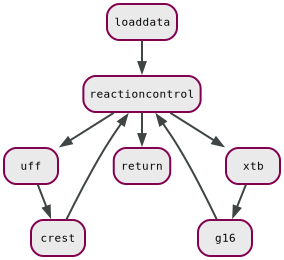

In [8]:
flow.visualize(max_level=0, labels=False)

## Run

Run the workflow, it will exit once all the calculations have completed.


:: Disclaimer ::

The workflow set-up here is meant to showcase the capabilities of Maize to set-up complex workflows. This current workflow is not designed to be executed on a jupyter-notebook, therefore performance and efficiency of the calculations generated here are not guaranteed. 

In [ ]:
flow.execute()